# Dynamic Time Warping of Speech Signals

In this tutorial we apply Dynamic Time Warping to align different speech signals, e.g. if you want
to synchronize two realizations of the same utterance.
______   




In [12]:
# Do the imports #
##################
#
%matplotlib inline
import os,sys 
import numpy as np
import math

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from IPython.display import display, Audio, HTML, clear_output
import ipywidgets as widgets
from ipywidgets import Box, HBox, VBox, Layout,interactive
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
#
import librosa
import pyspch.sp as Sps
import pyspch.core as Spch
import pyspch.display as Spd
import pyspch.dtw as dtw

    
# make notebook cells stretch over the full screen
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

mpl.rcParams['figure.figsize'] = [12.0, 8.0]
mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'large'

In the sequal we illustrate following utterance synchronization algorithm

1. Load two speech signals - same utterance spoken by 2 different speakers
2. compute Fourier Spectra and Mel Spectra
3. Use the mel spectra to find the best possible alignment between both signals
4. apply the warping function to the Fourier spectra
5. resynthesize both signals using the Griffin-Lim synthesis from spectral magnitude

In [2]:
dir = 'https://homes.esat.kuleuven.be/~spchlab/data/'
# sa1: she had your dark suit in greasy washwater all year
# sa2: don't ask me to carry an oily rag like that
# note there are some word segmentation errors in sa1, phn segmentations are OK
yname = dir+'timit/audio/train/dr1/fcjf0/sa2'
xname = dir+'timit/audio/train/dr1/fdaw0/sa2'
#
#yname = dir+'digits/5752'
#xname = dir+'digits/2927'
xwavdata, sr = Spch.load(xname+".wav")
ywavdata, sr = Spch.load(yname+".wav")

xsegdata = Spch.read_seg_file(xname+ ".wrd",dt=1/sr,fmt='float32')
ysegdata = Spch.read_seg_file(yname+ ".wrd",dt=1/sr,fmt='float32')
# compute a spectrogram with default parameters

n_mels = None
shift=0.01
length=0.03
n_shift = int(shift*sr)
n_length = int(length*sr)
#
xspgdata = Sps.spectrogram(xwavdata,sample_rate=sr,f_shift=shift,preemp=0.,n_mels=None)
xmeldata = Sps.spectrogram(xwavdata,sample_rate=sr,f_shift=shift,n_mels=24)
(nparam,xnfr)=xspgdata.shape
d_freq = sr/(2.*(nparam-1))
yspgdata = Sps.spectrogram(ywavdata,sample_rate=sr,f_shift=shift,preemp=0.,n_mels=None)
ymeldata = Sps.spectrogram(ywavdata,sample_rate=sr,f_shift=shift,n_mels=24)

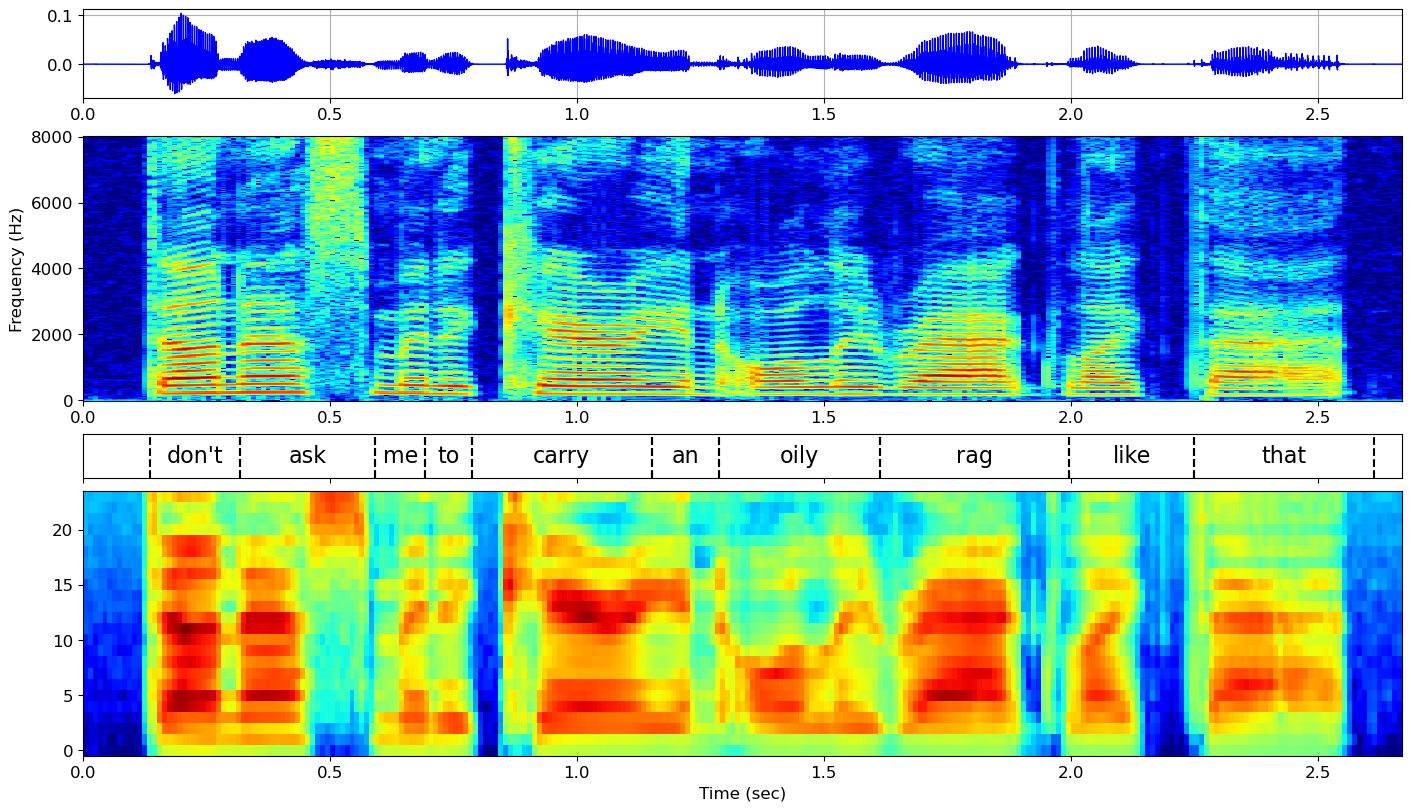

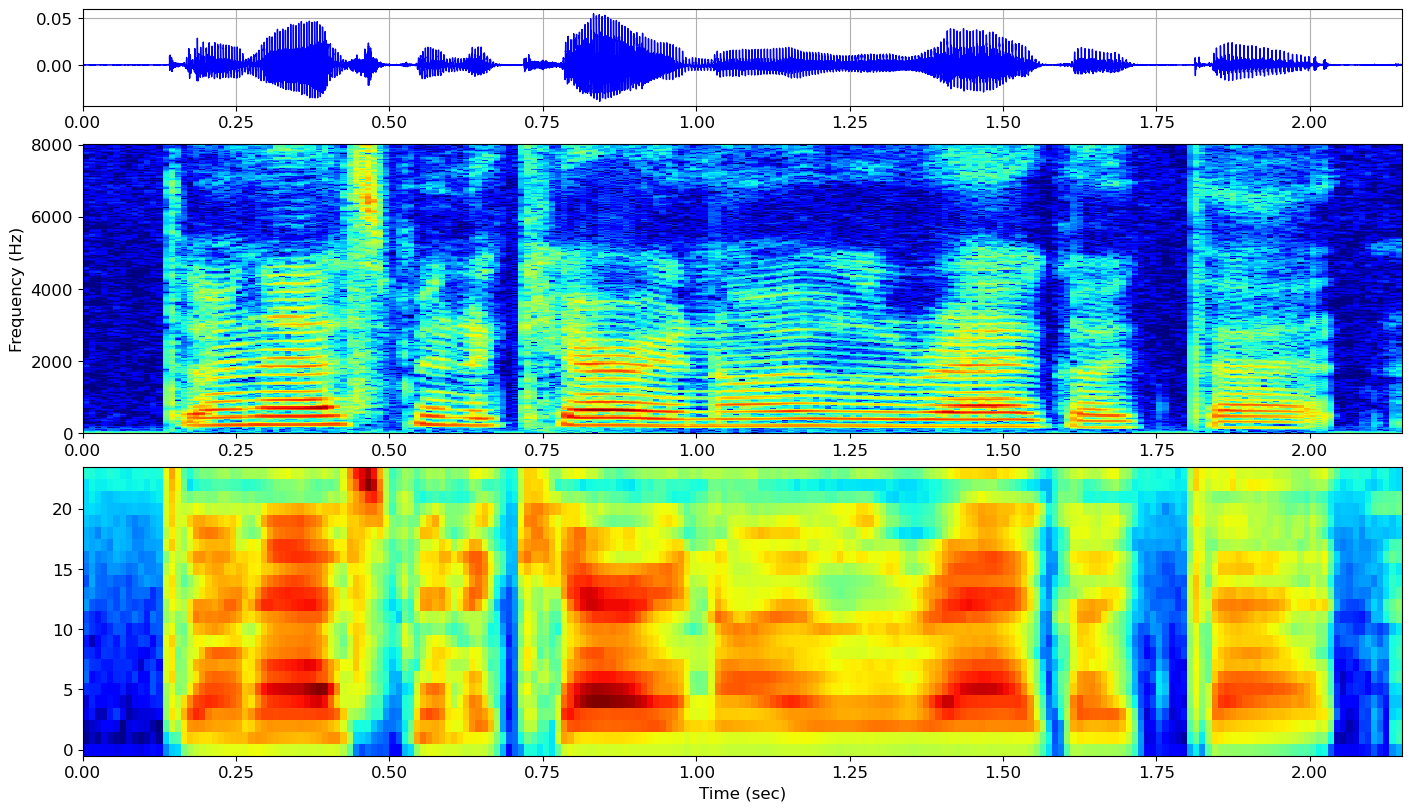

In [3]:
# just displaying the spectrograms and mel spectrograms of both sentences
fig = Spd.PlotSpgFtrs(wavdata=xwavdata,spgdata=xspgdata,segdata=[xsegdata],
                      img_ftrs=[xmeldata],sample_rate=sr,dy=d_freq,figsize=(14,8))
display(fig)
#
fig = Spd.PlotSpgFtrs(wavdata=ywavdata,spgdata=yspgdata, #segwav=ysegdata,
                  img_ftrs=[ymeldata],sample_rate=sr,dy=d_freq,figsize=(14,8))
display(fig)

## Dynamic Time Warping of the feature vectors

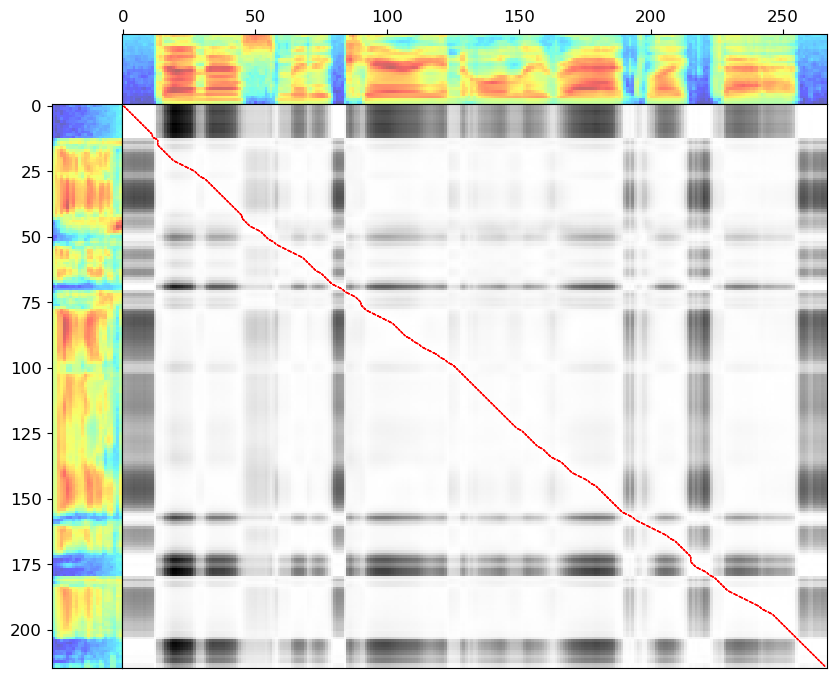

In [28]:
plt_args = {'fig_width':10,'ftr_scale':.1,'ftr_args':{'cmap':'jet','edgecolor':None},
            'xy_args':{'cmap':'Greys','alpha':1} }
x_ftrs = xmeldata.T
y_ftrs = ymeldata.T
#x_ftrs = xspgdata.T
#y_ftrs = yspgdata.T

cost,trace,ld_matrix,cd_matrix,_ = dtw.dtw(x_ftrs,y_ftrs,trans='ITY',result='details')
fig = dtw.plot_trellis(xy_mat=ld_matrix,trace=trace,y=y_ftrs,x=x_ftrs,**plt_args)
#fig = dtw.plot_trellis(xy_mat=ld_matrix,x=x_ftrs,y=y_ftrs)
#fig = dtw.plot_trellis(xy_mat=ld_matrix,trace=trace,y=yspgdata[0:255,:].T,x=xspgdata[0:255,:].T,**plt_args)
fig

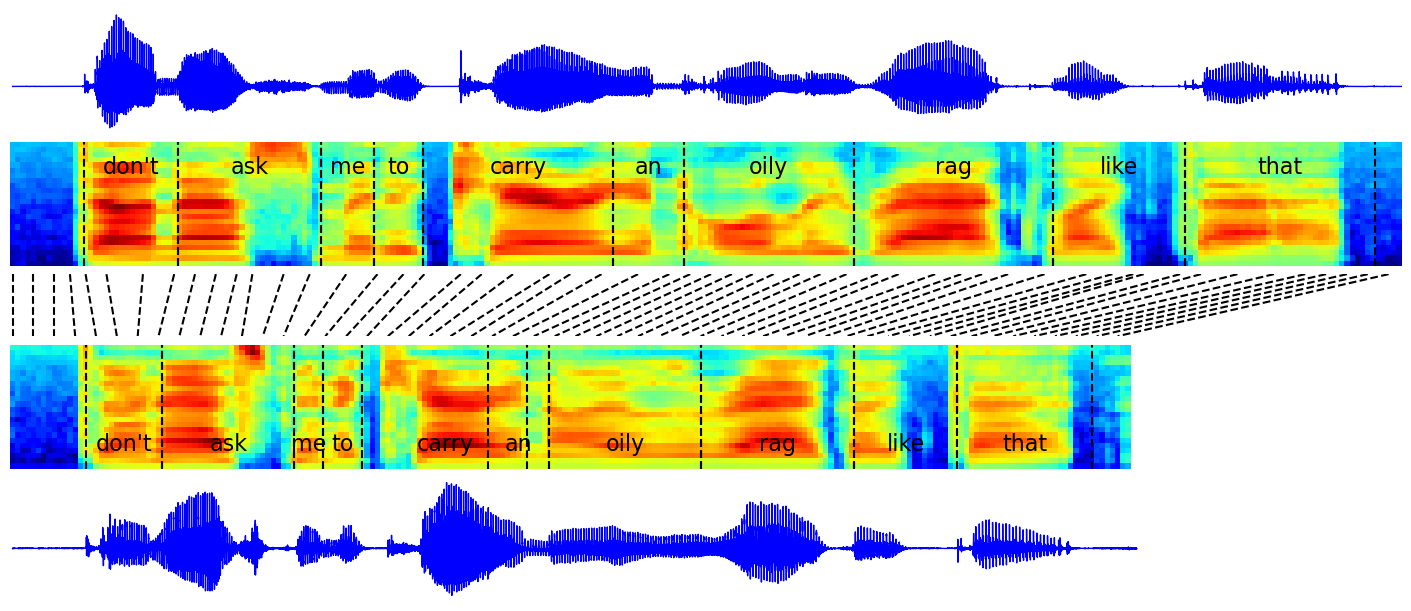

In [29]:
# plot the feature vectors together with their alignment
dtw.plot_align(x_ftrs,y_ftrs,trace,x_wav=xwavdata,y_wav=ywavdata,sr=sr,x_seg=xsegdata,y_seg=ysegdata,cmap='jet',segcolor='k',down_sample=4,figsize=(14,6))

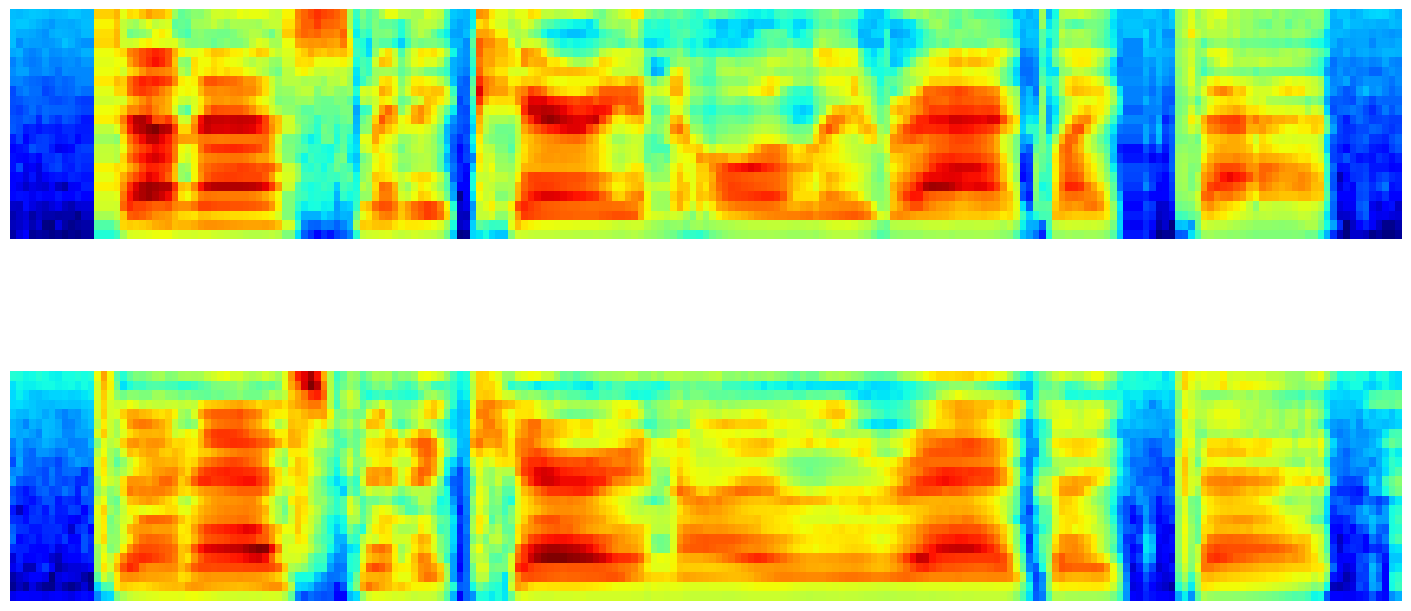

In [30]:
# warp the feature vectors and plot them side by side
x_wp,y_wp = dtw.warp(x_ftrs,y_ftrs,trace)
dtw.plot_align(x_wp,y_wp,None,cmap='jet',down_sample=3,figsize=(14,6))

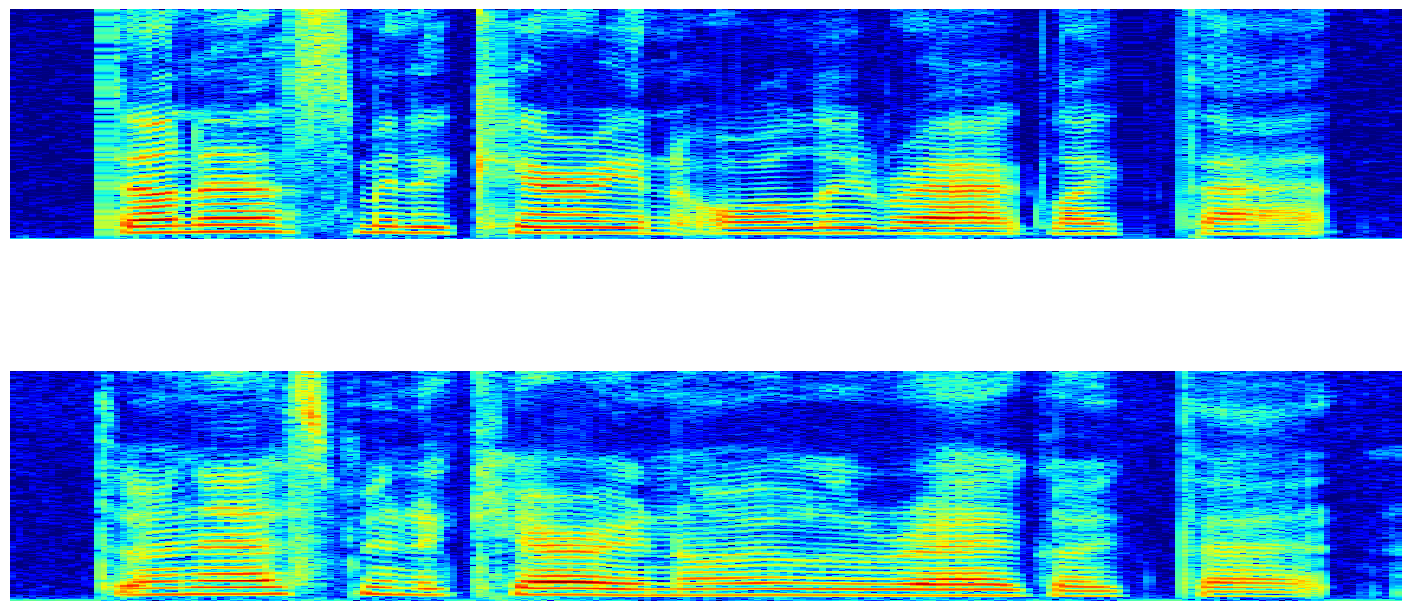

In [31]:
# Use the mel warping function to warp the spectrogram data
x_wpspg,y_wpspg = dtw.warp(xspgdata.T,yspgdata.T,trace)
dtw.plot_align(x_wpspg,y_wpspg,None,cmap='jet',down_sample=3,figsize=(14,6))

In [32]:
#
def glim_synt(x,sample_rate=8000,shift=0.01):
    # dB to magnitude
    x_mag = librosa.db_to_power(x) **0.5
    hop_length = int(shift*sample_rate)
    xsyn = librosa.griffinlim(x_mag,hop_length=hop_length)
    return(xsyn)

Original spkr1


Warped spkr1


Original spkr2


Warped spkr2


Duo Speech


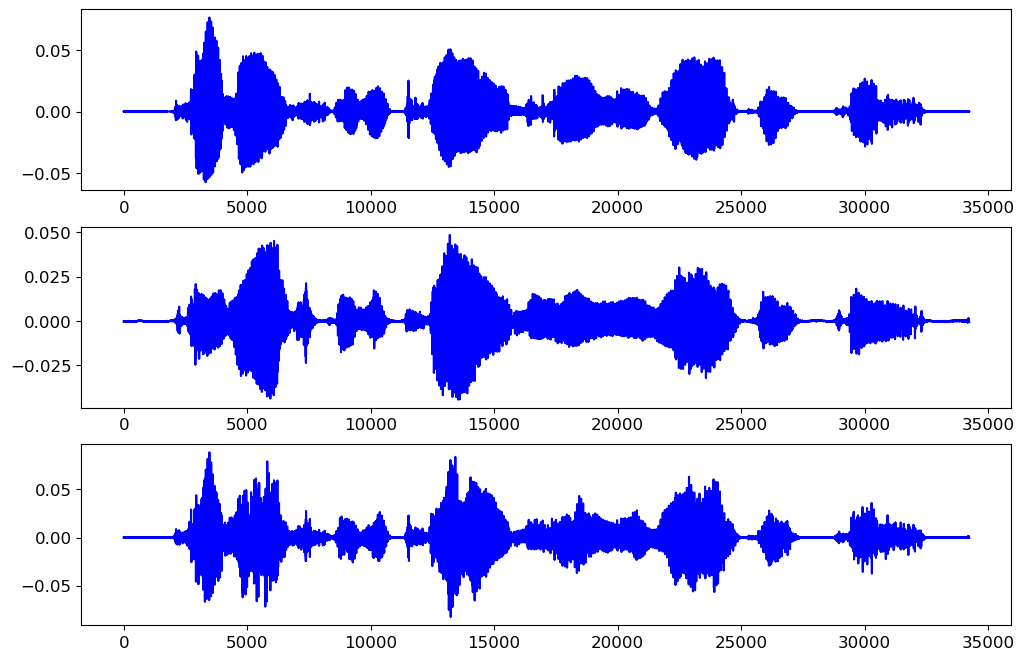

In [36]:
x_syn = Sps.synth_griffinlim(x_wpspg.T,sample_rate=sr)
y_syn = Sps.synth_griffinlim(y_wpspg.T,sample_rate=sr)
fig,ax = plt.subplots(3)
ax[0].plot(x_syn)
ax[1].plot(y_syn)
ax[2].plot(x_syn+y_syn)
print("Original spkr1")
display(Audio(xwavdata,rate=sr))
print("Warped spkr1")
display(Audio(x_syn,rate=sr))
print("Original spkr2")
display(Audio(ywavdata,rate=sr))
print("Warped spkr2")
display(Audio(y_syn,rate=sr))
print("Duo Speech")
display(Audio(x_syn+y_syn,rate=sr))

In [34]:
# saving the synchronized outputs
# Spch.audio.save("synced_data.wav",x_syn+y_syn,sr)

## Compare with a DUMB linear alignment between X and Y

In [22]:
def linear_warp(Nx,Ny):
    ' make a linear trace mapping x[Nx] to y[Ny] '
    N = (Nx+Ny)//2
    trace = np.zeros((N,2),dtype='int')
    for i in range(0,N):
        trace[i,0] = (i*Nx)//N
        trace[i,1] = (i*Ny)//N
    return(trace)

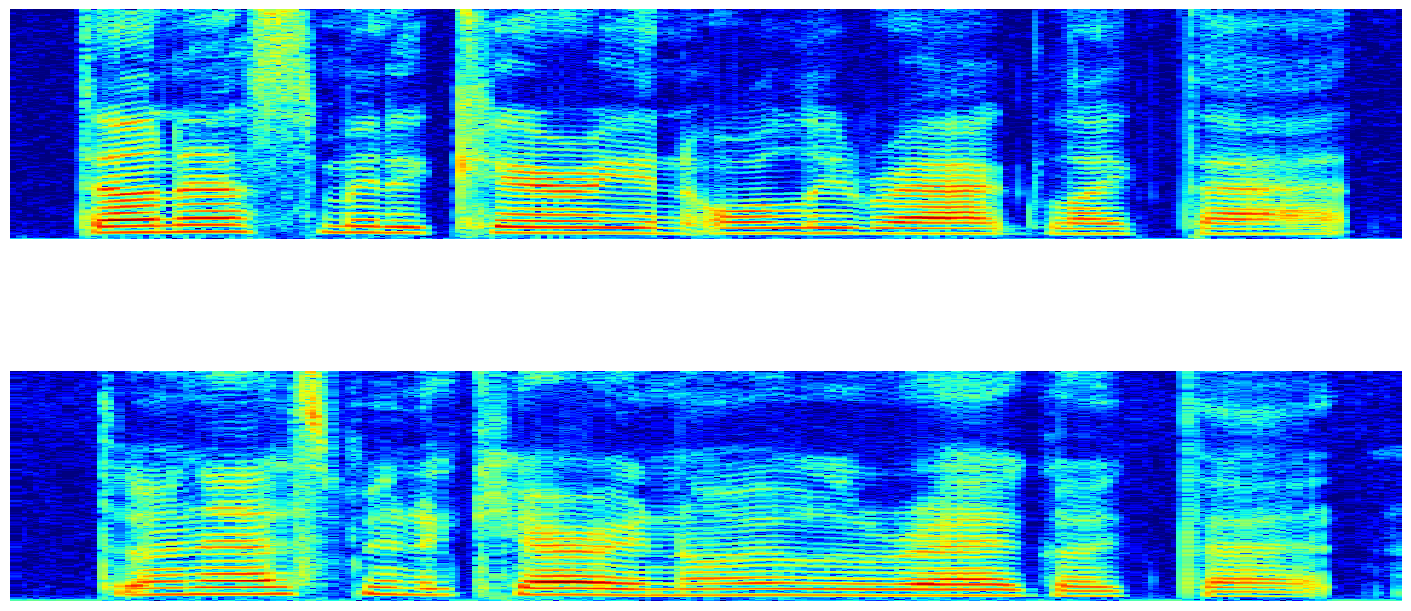

In [23]:
# Use the mel warping function to warp the spectrogram data
lin_trace = linear_warp(xspgdata.shape[1],yspgdata.shape[1])
x_wplspg,y_wplspg = dtw.warp(xspgdata.T,yspgdata.T,lin_trace)
dtw.plot_align(x_wplspg,y_wplspg,None,cmap='jet',down_sample=3,figsize=(14,6))

Original spkr1


Warped spkr1


Original spkr2


Warped spkr2


Duo Speech


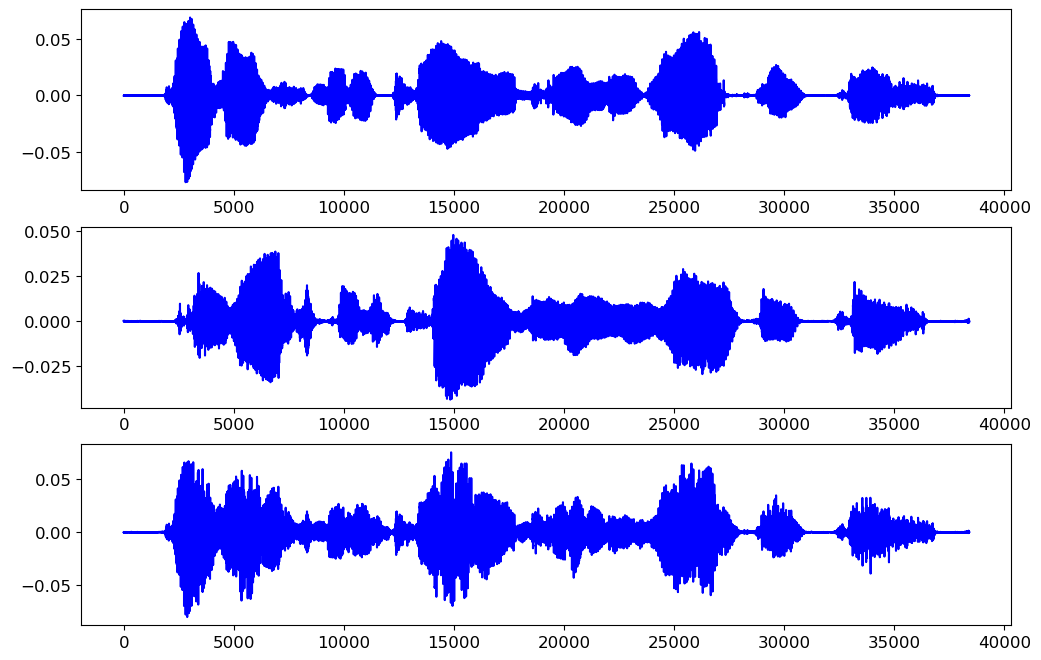

In [35]:
xl_syn = Sps.synth_griffinlim(x_wplspg.T,sample_rate=sr)
yl_syn = Sps.synth_griffinlim(y_wplspg.T,sample_rate=sr)
fig,ax = plt.subplots(3)
ax[0].plot(xl_syn)
ax[1].plot(yl_syn)
ax[2].plot(xl_syn+yl_syn)
print("Original spkr1")
display(Audio(xwavdata,rate=sr))
print("Warped spkr1")
display(Audio(xl_syn,rate=sr))
print("Original spkr2")
display(Audio(ywavdata,rate=sr))
print("Warped spkr2")
display(Audio(yl_syn,rate=sr))
print("Duo Speech")
display(Audio(xl_syn+yl_syn,rate=sr)) 